## Sprint I - Asunciones

**Hecho el 25/01:** 
- comprobamos normalidad, homogeneidad y dependencia.
- hemos creado un csv nuevo con la v respuesta normalizada para hacer con ella otro anova.
- separamos ficheros de encoding y anova.

In [178]:
import numpy as np
import pandas as pd
import random 

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.multivariate.manova import MANOVA
from sklearn.preprocessing import StandardScaler
import math 
from sklearn.preprocessing import MinMaxScaler
import researchpy as rp
from scipy.stats import levene
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (10,8) 

In [179]:
df = pd.read_csv("../datos/bikes_clean.csv", index_col= 0)
df.reset_index(drop=True, inplace=True)
df.head()

,season,yr,mnth,holiday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,weekday
0,winter,0,1,1,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985,1
1,winter,0,2,0,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801,4
2,winter,0,3,0,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,4
3,spring,0,4,0,0,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,7
4,spring,0,5,0,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,2


## Asunción de normalidad de nuestra variable respuesta

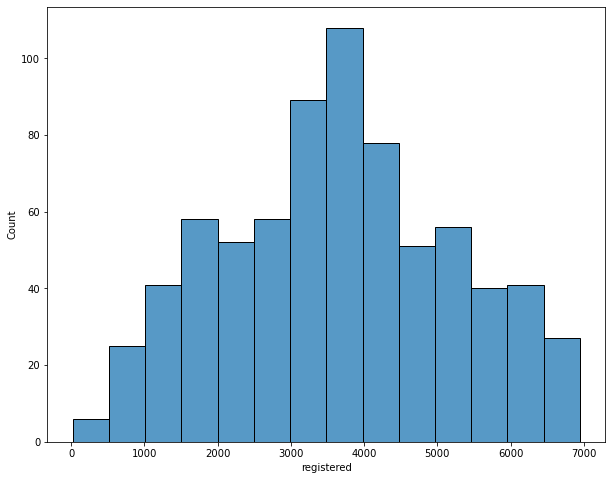

In [180]:
sns.histplot(df["registered"]) ;

In [181]:
stats.shapiro(df["registered"])

ShapiroResult(statistic=0.98438560962677, pvalue=5.023745757171127e-07)

- Nuestro pvalor es menor a 0.05, con lo cual nuestros datos no son normales.

## Asunción de dependencia

In [182]:
num = df.select_dtypes(include=np.number).drop("registered", axis = 1)

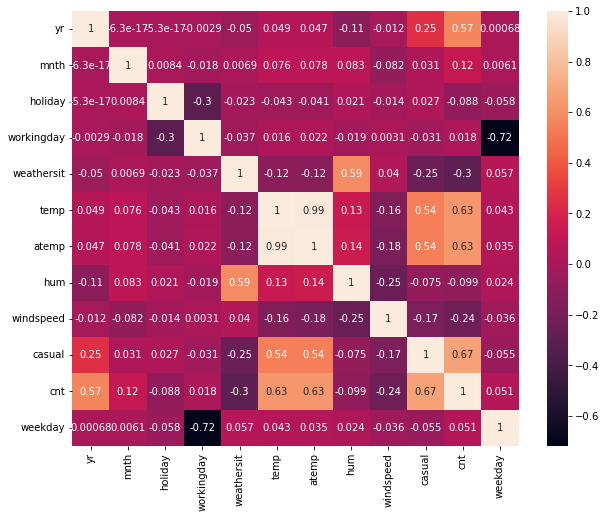

In [183]:
sns.heatmap(num.corr(), annot=True) ;

- Observamos que la columna atemp está muy relacionada con la temp, por lo que decidimos eliminarla.

In [184]:
df.drop("atemp", axis=1, inplace= True)

## Asunción de homocedasticidad / homocedasticidad

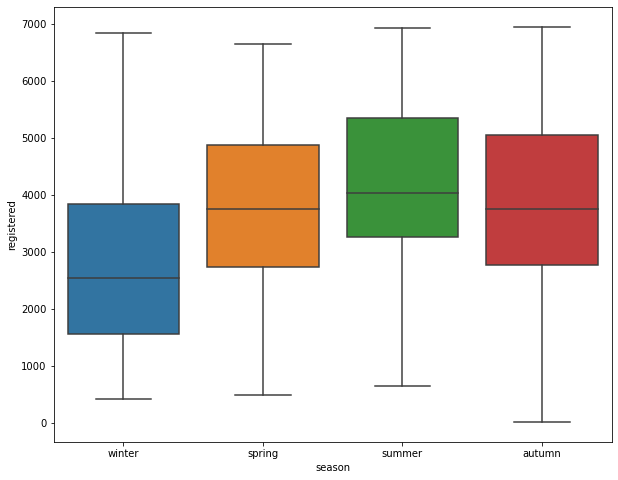

In [185]:
sns.boxplot(y= "registered", x="season", data = df) ;

- Nuestros datos son heterocedásticos, hacemos un test de levene para comprobarlo numéricamente.

In [186]:
winter = df[df["season"] == 'winter']["registered"]
spring = df[df["season"] == 'spring']["registered"]
summer = df[df["season"] == 'summer']["registered"]
autumn = df[df["season"] == 'autumn']["registered"]

In [187]:
levene_test = stats.levene(winter, spring, summer, autumn, center='median')
levene_test

LeveneResult(statistic=0.9363377313603704, pvalue=0.42259170002446245)

- Observamos que nuestros datos son mayores que 0.05, por lo que son homocedásticos. Nos quedamos con los resultados del test de Levene.

## Normalización de la variable respuesta

In [188]:
minmax = MinMaxScaler()

In [189]:
minmax.fit(df[["registered"]])

MinMaxScaler()

In [190]:
x_norm = minmax.transform(df[["registered"]])

In [191]:
x_norm.min(axis=0)

array([0.])

In [192]:
x_norm.max(axis=0)

array([1.])

In [193]:
num_minmax = pd.DataFrame(x_norm, columns=["registered_Sklearn"])

In [194]:
df["registered_Sklearn"]= num_minmax

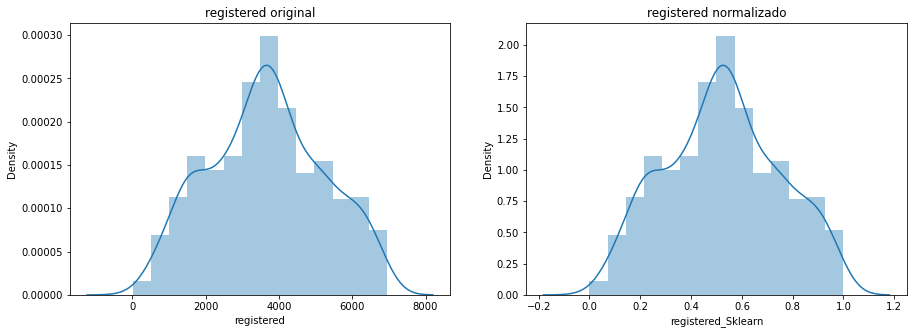

In [195]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('registered original')
axes[1].set_title('registered normalizado')

sns.distplot(df['registered'] ,ax = axes[0])
sns.distplot(df['registered_Sklearn'], ax = axes[1]);

In [196]:
stats.shapiro(df["registered_Sklearn"])

ShapiroResult(statistic=0.98438560962677, pvalue=5.023745757171127e-07)

Probamos con el BOX-COX

In [197]:
df['registered_BOX'], lambda_ajustada = stats.boxcox(df['registered'])

In [198]:
stats.shapiro(df["registered_BOX"])

ShapiroResult(statistic=0.9854231476783752, pvalue=1.1639369859040016e-06)

Sigue sin normalizar

***
## ANOVA con todas las columnas
***

In [199]:
df = pd.read_csv("../datos/bikes_clean.csv", index_col = 0)

In [200]:
df.head(2)

,season,yr,mnth,holiday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,weekday
instant,,,,,,,,,,,,,,
1,winter,0,1,1,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985,1
2,winter,0,2,0,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801,4


sklearn entenderá los valores numéricos como **encoding**.

In [201]:
df.columns

Index(['season', 'yr', 'mnth', 'holiday', 'workingday', 'weathersit', 'temp',
       'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt', 'weekday'],
      dtype='object')

In [202]:
df.isnull().sum()

season        0
yr            0
mnth          0
holiday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
weekday       0
dtype: int64

In [203]:
df.shape

(730, 14)

In [204]:
df.columns

Index(['season', 'yr', 'mnth', 'holiday', 'workingday', 'weathersit', 'temp',
       'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt', 'weekday'],
      dtype='object')

In [205]:
lm = ols('registered ~ season + yr + mnth + holiday + workingday + weathersit + temp + atemp + hum + windspeed + weekday', data=df).fit()
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
season,3.0,1.881109e+08,6.270365e+07,87.947060,1.869401e-48
yr,1.0,6.319184e+08,6.319184e+08,886.317847,2.297536e-127
mnth,1.0,1.845005e+07,1.845005e+07,25.877721,4.651071e-07
holiday,1.0,1.110604e+07,1.110604e+07,15.577142,8.701703e-05
workingday,1.0,2.628858e+05,2.628858e+05,0.368719,5.438958e-01
weathersit,1.0,8.260723e+07,8.260723e+07,115.863478,3.792705e-25
temp,1.0,2.855805e+08,2.855805e+08,400.550358,4.114273e-71
atemp,1.0,6.182051e+06,6.182051e+06,8.670838,3.338188e-03
hum,1.0,4.339402e+04,4.339402e+04,0.060864,8.052067e-01
windspeed,1.0,2.395524e+07,2.395524e+07,33.599205,1.015238e-08


In [206]:
len(df["registered"].unique())

678

In [207]:
df["registered"].value_counts().sum()

730

In [208]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             registered   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     136.3
Date:                Thu, 26 Jan 2023   Prob (F-statistic):          1.49e-183
Time:                        14:16:46   Log-Likelihood:                -5947.9
No. Observations:                 730   AIC:                         1.192e+04
Df Residuals:                     716   BIC:                         1.199e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2191.0842    339.762      6.449      0.000    1524.036    2858.133
season[T.spring]  -503.5824    136.132     -3.699      0.000    -770.849    -236.316
season[T.summer]  -474.3762    105.646     -4.490      0.000    -681.789    -266.964
season[T.winter]  -966.7047    159.473     -6.062      0.000   -1279.795    -653.614
yr                1752.9067     63.170     27.749      0.000    1628.886    1876.928
mnth               -34.4629     16.996     -2.028      0.043     -67.831      -1.094
holiday           -433.2693    183.482     -2.361      0.018    -793.496     -73.043
workingday         334.1584    111.697      2.992      0.003     114.866     553.451
weathersit        -448.0617     75.716     -5.918      0.000    -596.713    -299.411
temp                27.8960     33.532      0.832      0.406     -37.937      93.729
atemp               59.8087     30.941      1.933      0.054      -0.937     120.554
hum                 -4.1079      3.019     -1.361      0.174     -10.035       1.819
windspeed          -36.1994      6.583     -5.499      0.000     -49.124     -23.275
weekday            113.1459     24.799      4.563      0.000      64.459     161.833
==============================================================================
Omnibus:                       36.748   Durbin-Watson:                   0.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.727
Skew:                          -0.491   Prob(JB):                     1.94e-10
Kurtosis:                       3.711   Cond. No.                         864.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [209]:
df.head()

,season,yr,mnth,holiday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,weekday
instant,,,,,,,,,,,,,,
1,winter,0,1,1,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985,1
2,winter,0,2,0,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801,4
3,winter,0,3,0,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,4
4,spring,0,4,0,0,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,7
5,spring,0,5,0,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,2


- Year : El encoding estaría bien hecho ya porque el año 1 hay más bicis alquiladas
- Workingday : El encoding también estaría bien
- Weathersit : El encoding sería 1 - 2, para el 2 le ponemos un 1 y para el 3 le ponemos un 0

- Season : Hay que hacerlo. Verano 2, primavera y otoño 1, winter 0
- month lo borraremos porque nos da la misma información que las estaciones

## ENCODING

Empezamos por el weatherit

In [210]:
mapa = {3:0, 2:1, 1:2} 

In [211]:
df["weathersit_map"] = df["weathersit"].map(mapa)

In [212]:
df.sample(2)

,season,yr,mnth,holiday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,weekday,weathersit_map
instant,,,,,,,,,,,,,,,
419,winter,1,2,0,0,1,18.620847,22.22230,55.4583,12.791171,516,4546,5062,6,2
421,winter,1,2,0,1,1,11.924153,12.78375,39.5833,28.250014,317,2415,2732,1,2


In [213]:
mapa2 = {"winter":0, "autumn":1, "spring":1, "summer":2} 

In [214]:
df["season_map"] = df["season"].map(mapa2)

In [215]:
df.sample(5)

,season,yr,mnth,holiday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,weekday,weathersit_map,season_map
instant,,,,,,,,,,,,,,,,
435,autumn,1,11,0,0,1,14.831299,17.98350,47.6957,14.913329,1658,3253,4911,7,2,1
543,summer,1,6,0,1,1,28.597500,32.03960,36.0000,18.208925,1077,6258,7335,4,2,2
330,autumn,0,11,0,1,1,15.409153,19.25435,68.1667,4.584194,1249,1819,3068,1,2,1
384,winter,1,1,0,0,1,7.790000,9.50190,49.7500,14.750586,130,3162,3292,6,2,0
611,winter,1,3,0,0,1,29.007500,33.08145,79.0833,10.125107,1965,4069,6034,6,2,0


In [ ]:
df2 = df.drop(columns=["season", "mnth", "weathersit"])